<a href="https://colab.research.google.com/github/SangminAhn21/DL_Study/blob/main/Kaggle/Facial_Keypoint_Detection/FKD_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
%cd drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection

/content/drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection


In [4]:
pip install kaggle

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [6]:
!kaggle competitions download -c facial-keypoints-detection

test.zip: Skipping, found more recently modified local copy (use --force to force download)
SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
training.zip: Skipping, found more recently modified local copy (use --force to force download)
IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip training.zip
!unzip test.zip

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [12]:
import models, utils

In [8]:
import numpy as np
import pandas as pd



training_pd = pd.read_csv('training.csv')
test_pd = pd.read_csv('test.csv')

training_pd = training_pd.fillna(method='ffill')

training = training_pd.to_numpy()
test = test_pd.to_numpy()

train_image = training[:, -1]
train_key = training[:, :-1].astype('float64')
test_image = test[:, 1]

train_image = np.array([np.array([int(pixel) for pixel in image.split()]).\
                        reshape(96, 96) for image in train_image])
test_image = np.array([np.array([int(pixel) for pixel in image.split()]).\
                       reshape(96, 96) for image in test_image])

In [9]:
pip install ray

     |████████████████████████████████| 54.7 MB 34 kB/s 
     |████████████████████████████████| 118 kB 46.5 MB/s 


In [32]:
pip install -U tensorboardx

     |████████████████████████████████| 124 kB 5.5 MB/s 


In [35]:
from utils import FaceDataset, RMSELoss
from functools import partial
from models import CNN
import numpy as np
import torch
from torch.utils.data import DataLoader
import os
from filelock import FileLock
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


def cnn_train(config, data, checkpoint_dir=None, data_dir=None):
    if torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')
    print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

    model = CNN(config['l1'], config['l2']).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])
    criterion = RMSELoss()
    print(model)


    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)


    data_dir = os.path.abspath("./data")
    dataset = FaceDataset(data[0], data[1])

    lengths = [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)]
    train_data, val_data = torch.utils.data.random_split(dataset, lengths)

    train_loader = DataLoader(dataset=train_data,
                          batch_size=config['batch_size'],
                          shuffle=True,
                          num_workers=2)
    val_loader = DataLoader(dataset=val_data,
                        batch_size=config['batch_size'],
                        shuffle=True,
                        num_workers=2)

    # model.train()
    for Epoch in range(20):
        # running_loss = 0.0
        # epoch_steps = 0
        for batch_idx, (image, key) in enumerate(train_loader):
            image = image.to(DEVICE)
            key = key.to(DEVICE)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, key)
            loss.backward()
            optimizer.step()

            # running_loss += loss.item()
            # epoch_steps += 1

            if batch_idx % 100 == 0:
                print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                    Epoch, batch_idx * len(image),
                    len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                    loss.item()))
                # running_loss = 0.0

        # model.eval()
        val_loss = 0.0
        for image, key in val_loader:
            with torch.no_grad():
                image = image.to(DEVICE)
                key = key.to(DEVICE)
                output = model(image)
                val_loss += criterion(output, key).item()

        val_loss /= len(val_loader.dataset)
        val_loss *= config['batch_size']
        print('\n[EPOCH: {}], \tVal Loss: {:.4f}\n'.
        format(Epoch, val_loss))

        with tune.checkpoint_dir(Epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=val_loss)
    print("Finished Training")

In [36]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    data_dir = os.path.abspath("./data")  # 특정 경로에 대해 절대 경로 얻기
    config = {
        'l1': tune.sample_from(lambda _: 2**np.random.randint(3, 8)),
        'l2': tune.sample_from(lambda _: 2**np.random.randint(3, 8)),
        'lr': tune.loguniform(1e-3, 1e-1),
        'batch_size': tune.choice([8, 16, 32])
    }
    scheduler = ASHAScheduler(
        metric='loss',
        mode='min',
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "training_iteration"])
    
    result = tune.run(
        tune.with_parameters(partial(cnn_train, data_dir=data_dir), data=(train_image, train_key)),
        resources_per_trial={'cpu': 1, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))

    best_trained_model = CNN(best_trial.config["l1"], best_trial.config["l2"])
    if torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')
    best_trained_model.to(DEVICE)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    PATH = '/content/drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection/saved_model/'
    torch.save(best_trained_model, PATH + str(best_trial.config) + 'val_loss: ' + str(best_trial.last_result['loss']))

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=20, gpus_per_trial=1)

== Status ==
Current time: 2021-11-19 07:26:07 (running for 00:00:00.21)
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (10 PENDING)
+----------------------------------+----------+-------+--------------+------+------+------------+
| Trial name                       | status   | loc   |   batch_size |   l1 |   l2 |         lr |
|----------------------------------+----------+-------+--------------+------+------+------------|
| tune_with_parameters_f6201_00000 | PENDING  |       |           16 |   64 |   32 | 0.0323551  |
| tune_with_parameters_f6201_00001 | PENDING  |       |           64 |    8 |   16 | 0.0317033  |
| tune_with_parameters_f6201_00002 

(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)
(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


(scheduler +14m28s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(ImplicitFunc pid=1570) Using PyTorch version: 1.10.0+cu111  Device:  cuda
== Status ==
Current time: 2021-11-19 07:26:12 (running for 00:00:05.22)
Memory usage on this node: 4.9/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------------+----------+-----------------+--------------+------+------+------------+
| Trial name                       | status   | loc             |   b

(pid=1570) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=1570)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=1570) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.346024
(ImplicitFunc pid=1570) Train Epoch: 0 [1600/5639(28%)]	Train Loss: 5.985302
(ImplicitFunc pid=1570) Train Epoch: 0 [3200/5639(57%)]	Train Loss: 2.934462
(ImplicitFunc pid=1570) Train Epoch: 0 [4800/5639(85%)]	Train Loss: 5.582454
Result for tune_with_parameters_f6201_00000:
  date: 2021-11-19_07-26-17
  done: false
  experiment_id: ba0393095888428797db4ab915fd4ebd
  hostname: ecc602ac4891
  iterations_since_restore: 1
  loss: 3.265287729357997
  node_ip: 172.28.0.2
  pid: 1570
  should_checkpoint: true
  time_since_restore: 6.37751030921936
  time_this_iter_s: 6.37751030921936
  time_total_s: 6.37751030921936
  timestamp: 1637306777
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f6201_00000
  
(ImplicitFunc pid=1570) 
(ImplicitFunc pid=1570) [EPOCH: 0], 	Val Loss: 3.2653
(ImplicitFunc pid=1570) 
(ImplicitFunc pid=1570) Train Epoch: 1 [0/5639(0%)]	Train Loss: 3.125282
(ImplicitFunc pid=1570) Tra

(pid=1569) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=1569)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=1569) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.862083
Result for tune_with_parameters_f6201_00001:
  date: 2021-11-19_07-27-27
  done: true
  experiment_id: 1a3eb71451b24c7b8b6805acb1b01eb7
  hostname: ecc602ac4891
  iterations_since_restore: 1
  loss: 4.078365331338652
  node_ip: 172.28.0.2
  pid: 1569
  should_checkpoint: true
  time_since_restore: 4.134280681610107
  time_this_iter_s: 4.134280681610107
  time_total_s: 4.134280681610107
  timestamp: 1637306847
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f6201_00001
  
(ImplicitFunc pid=1569) 
(ImplicitFunc pid=1569) [EPOCH: 0], 	Val Loss: 4.0784
(ImplicitFunc pid=1569) 


(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


(ImplicitFunc pid=2068) Using PyTorch version: 1.10.0+cu111  Device:  cuda
== Status ==
Current time: 2021-11-19 07:27:30 (running for 00:01:23.39)
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -3.0913814233549943 | Iter 8.000: -3.5243866426724915 | Iter 4.000: -3.8952432781246538 | Iter 2.000: -5.030723950541612 | Iter 1.000: -3.6718265303483246
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+-------------

(pid=2068) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=2068)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=2068) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.836361
(ImplicitFunc pid=2068) Train Epoch: 0 [1600/5639(28%)]	Train Loss: 3.554539
(ImplicitFunc pid=2068) Train Epoch: 0 [3200/5639(57%)]	Train Loss: 3.025815
(ImplicitFunc pid=2068) Train Epoch: 0 [4800/5639(85%)]	Train Loss: 4.119226
== Status ==
Current time: 2021-11-19 07:27:35 (running for 00:01:28.41)
Memory usage on this node: 5.4/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -3.0913814233549943 | Iter 8.000: -3.5243866426724915 | Iter 4.000: -3.8952432781246538 | Iter 2.000: -5.030723950541612 | Iter 1.000: -3.6718265303483246
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------

(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


== Status ==
Current time: 2021-11-19 07:28:43 (running for 00:02:35.61)
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -2.716549545991505 | Iter 8.000: -3.08265448022396 | Iter 4.000: -3.423713470350766 | Iter 2.000: -4.2809074794147035 | Iter 1.000: -3.265287729357997
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------

(pid=2514) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=2514)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=2514) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.874329
(ImplicitFunc pid=2514) Train Epoch: 0 [3200/5639(56%)]	Train Loss: 2.967177
Result for tune_with_parameters_f6201_00003:
  date: 2021-11-19_07-28-48
  done: false
  experiment_id: 70e3cd2e9c364141ae66d084bfbaf2c0
  hostname: ecc602ac4891
  iterations_since_restore: 1
  loss: 3.197047765204247
  node_ip: 172.28.0.2
  pid: 2514
  should_checkpoint: true
  time_since_restore: 5.032159328460693
  time_this_iter_s: 5.032159328460693
  time_total_s: 5.032159328460693
  timestamp: 1637306928
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f6201_00003
  
== Status ==
Current time: 2021-11-19 07:28:48 (running for 00:02:41.28)
Memory usage on this node: 5.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -2.716549545991505 | Iter 8.000: -3.08265448022396 | Iter 4.000: -3.423713470350766 | Iter 2.000: -4.2809074794147035 | Iter 1.000: -3.231167747281122
Resources requested: 1.0/2 CPUs, 

(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


(ImplicitFunc pid=2710) Using PyTorch version: 1.10.0+cu111  Device:  cuda
== Status ==
Current time: 2021-11-19 07:29:06 (running for 00:02:59.10)
Memory usage on this node: 4.7/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -2.716549545991505 | Iter 8.000: -3.0945989838728667 | Iter 4.000: -3.256529013992201 | Iter 2.000: -3.531091008287795 | Iter 1.000: -3.231167747281122
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+----------------

(pid=2710) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=2710)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=2710) Train Epoch: 0 [0/5639(0%)]	Train Loss: 52.096420
Result for tune_with_parameters_f6201_00004:
  date: 2021-11-19_07-29-09
  done: true
  experiment_id: 59b5200faad44a30bcbcd623ede66f70
  hostname: ecc602ac4891
  iterations_since_restore: 1
  loss: 3.7278969730891234
  node_ip: 172.28.0.2
  pid: 2710
  should_checkpoint: true
  time_since_restore: 4.112268447875977
  time_this_iter_s: 4.112268447875977
  time_total_s: 4.112268447875977
  timestamp: 1637306949
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f6201_00004
  
(ImplicitFunc pid=2710) 
(ImplicitFunc pid=2710) [EPOCH: 0], 	Val Loss: 3.7279
(ImplicitFunc pid=2710) 


(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


(ImplicitFunc pid=2762) Using PyTorch version: 1.10.0+cu111  Device:  cuda
== Status ==
Current time: 2021-11-19 07:29:12 (running for 00:03:04.75)
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -2.716549545991505 | Iter 8.000: -3.0945989838728667 | Iter 4.000: -3.256529013992201 | Iter 2.000: -3.531091008287795 | Iter 1.000: -3.265287729357997
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+----------------

(pid=2762) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=2762)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=2762) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.869934
(ImplicitFunc pid=2762) Train Epoch: 0 [800/5639(14%)]	Train Loss: 3.480902
(ImplicitFunc pid=2762) Train Epoch: 0 [1600/5639(28%)]	Train Loss: 3.243412
(ImplicitFunc pid=2762) Train Epoch: 0 [2400/5639(43%)]	Train Loss: 2.916823
== Status ==
Current time: 2021-11-19 07:29:17 (running for 00:03:09.81)
Memory usage on this node: 5.4/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -2.716549545991505 | Iter 8.000: -3.0945989838728667 | Iter 4.000: -3.256529013992201 | Iter 2.000: -3.531091008287795 | Iter 1.000: -3.265287729357997
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+---

(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


== Status ==
Current time: 2021-11-19 07:30:53 (running for 00:04:45.93)
Memory usage on this node: 3.9/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -2.835878148315646 | Iter 8.000: -3.061555337567701 | Iter 4.000: -3.10435633828454 | Iter 2.000: -3.4538943906202384 | Iter 1.000: -3.231167747281122
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------

(pid=3126) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=3126)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=3126) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.921406
== Status ==
Current time: 2021-11-19 07:30:58 (running for 00:04:51.48)
Memory usage on this node: 5.3/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -2.835878148315646 | Iter 8.000: -3.061555337567701 | Iter 4.000: -3.10435633828454 | Iter 2.000: -3.4538943906202384 | Iter 1.000: -3.231167747281122
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+-----------------+

(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


(ImplicitFunc pid=3178) Using PyTorch version: 1.10.0+cu111  Device:  cuda
== Status ==
Current time: 2021-11-19 07:31:04 (running for 00:04:56.83)
Memory usage on this node: 5.1/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -2.835878148315646 | Iter 8.000: -3.061555337567701 | Iter 4.000: -3.10435633828454 | Iter 2.000: -3.4538943906202384 | Iter 1.000: -3.265287729357997
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+-----------------

(pid=3178) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=3178)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=3178) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.200623
(ImplicitFunc pid=3178) Train Epoch: 0 [1600/5639(28%)]	Train Loss: 3.315352
(ImplicitFunc pid=3178) Train Epoch: 0 [3200/5639(57%)]	Train Loss: 3.259130
(ImplicitFunc pid=3178) Train Epoch: 0 [4800/5639(85%)]	Train Loss: 3.044051
Result for tune_with_parameters_f6201_00007:
  date: 2021-11-19_07-31-07
  done: true
  experiment_id: 3dbfc4b7765047fba9e338dcf79265cc
  hostname: ecc602ac4891
  iterations_since_restore: 1
  loss: 3.348859289182839
  node_ip: 172.28.0.2
  pid: 3178
  should_checkpoint: true
  time_since_restore: 6.172968626022339
  time_this_iter_s: 6.172968626022339
  time_total_s: 6.172968626022339
  timestamp: 1637307067
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f6201_00007
  
(ImplicitFunc pid=3178) 
(ImplicitFunc pid=3178) [EPOCH: 0], 	Val Loss: 3.3489
(ImplicitFunc pid=3178) 


(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


(scheduler +19m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
== Status ==
Current time: 2021-11-19 07:31:09 (running for 00:05:02.53)
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -2.835878148315646 | Iter 8.000: -3.061555337567701 | Iter 4.000: -3.10435633828454 | Iter 2.000: -3.4538943906202384 | Iter 1.000: -3.3070735092704178
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name            

(pid=3230) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=3230)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=3230) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.524769
(ImplicitFunc pid=3230) Train Epoch: 0 [3200/5639(56%)]	Train Loss: 3.304287
Result for tune_with_parameters_f6201_00008:
  date: 2021-11-19_07-31-15
  done: false
  experiment_id: c6f5f9585bb44832b2ab6e43a1240150
  hostname: ecc602ac4891
  iterations_since_restore: 1
  loss: 3.1073670137013103
  node_ip: 172.28.0.2
  pid: 3230
  should_checkpoint: true
  time_since_restore: 4.886317253112793
  time_this_iter_s: 4.886317253112793
  time_total_s: 4.886317253112793
  timestamp: 1637307075
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f6201_00008
  
== Status ==
Current time: 2021-11-19 07:31:15 (running for 00:05:07.93)
Memory usage on this node: 5.3/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -2.835878148315646 | Iter 8.000: -3.061555337567701 | Iter 4.000: -3.10435633828454 | Iter 2.000: -3.4538943906202384 | Iter 1.000: -3.265287729357997
Resources requested: 1.0/2 CPUs,

(raylet) /usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)


(ImplicitFunc pid=3342) Using PyTorch version: 1.10.0+cu111  Device:  cuda
== Status ==
Current time: 2021-11-19 07:31:26 (running for 00:05:18.72)
Memory usage on this node: 5.0/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -2.835878148315646 | Iter 8.000: -3.061555337567701 | Iter 4.000: -3.1204218276003575 | Iter 2.000: -3.376697772952682 | Iter 1.000: -3.265287729357997
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-19_07-26-07
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+-----------------+---------

(pid=3342) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=3342)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=3342) Train Epoch: 0 [0/5639(0%)]	Train Loss: 51.851734
(ImplicitFunc pid=3342) Train Epoch: 0 [1600/5639(28%)]	Train Loss: 3.470809
(ImplicitFunc pid=3342) Train Epoch: 0 [3200/5639(57%)]	Train Loss: 3.304157
(ImplicitFunc pid=3342) Train Epoch: 0 [4800/5639(85%)]	Train Loss: 2.886860
Result for tune_with_parameters_f6201_00009:
  date: 2021-11-19_07-31-30
  done: false
  experiment_id: 5de7d7968e874b1eb01832bdc7c8ac0c
  hostname: ecc602ac4891
  iterations_since_restore: 1
  loss: 2.8633132664024408
  node_ip: 172.28.0.2
  pid: 3342
  should_checkpoint: true
  time_since_restore: 6.38401985168457
  time_this_iter_s: 6.38401985168457
  time_total_s: 6.38401985168457
  timestamp: 1637307090
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f6201_00009
  
(ImplicitFunc pid=3342) 
(ImplicitFunc pid=3342) [EPOCH: 0], 	Val Loss: 2.8633
(ImplicitFunc pid=3342) 
(ImplicitFunc pid=3342) Train Epoch: 1 [0/5639(0%)]	Train Loss: 2.662274
(ImplicitFunc pid=3342) Tr

2021-11-19 07:32:34,478	INFO tune.py:630 -- Total run time: 387.04 seconds (386.87 seconds for the tuning loop).


Result for tune_with_parameters_f6201_00009:
  date: 2021-11-19_07-32-34
  done: true
  experiment_id: 5de7d7968e874b1eb01832bdc7c8ac0c
  hostname: ecc602ac4891
  iterations_since_restore: 20
  loss: 2.247820578230188
  node_ip: 172.28.0.2
  pid: 3342
  should_checkpoint: true
  time_since_restore: 70.5871012210846
  time_this_iter_s: 3.3550705909729004
  time_total_s: 70.5871012210846
  timestamp: 1637307154
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: f6201_00009
  
(ImplicitFunc pid=3342) 
(ImplicitFunc pid=3342) [EPOCH: 19], 	Val Loss: 2.2478
(ImplicitFunc pid=3342) 
== Status ==
Current time: 2021-11-19 07:32:34 (running for 00:06:26.91)
Memory usage on this node: 5.0/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -2.5914811218883975 | Iter 8.000: -3.028511691262536 | Iter 4.000: -3.036302745088618 | Iter 2.000: -3.2002449783027593 | Iter 1.000: -3.231167747281122
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB obj

In [37]:
best_model = torch.load("/content/drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection/saved_model/{'l1': 128, 'l2': 16, 'lr': 0.005391064065783462, 'batch_size': 16}val_loss: 2.247820578230188")

In [13]:
import matplotlib.pyplot as plt

In [27]:
def predict(model, test_image, idx, plot=False):
    image_pred = torch.from_numpy(test_image[idx]).type(torch.FloatTensor).to(DEVICE)
    image_pred /= 255.
    with torch.no_grad():
        prediction = model(image_pred)
    image_pred = image_pred.cpu().numpy()*255.
    prediction = prediction.cpu().numpy().reshape(30)
    # answer = val_data[idx][1]

    if plot:
        fig, axis = plt.subplots()
        prediction_plot(image_pred, prediction, axis,\
                        'prediction plot for {}th image in val_data'.
                        format(idx))


def prediction_plot(image, keypoint, axis, title, answer=None):
    image = image.reshape(96, 96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    # axis.scatter(answer[0::2], answer[1::2], marker='x', color='r', s=20)
    plt.title(title)


In [15]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

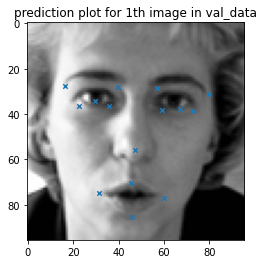

In [40]:
predict(model=best_model, test_image=train_image, idx=1, plot=True)